# Text classification with an RNN

Importing Required Modules

In [2]:
import zipfile

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Data Pre-Processing

In [3]:
zip_file_path = './archive.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    zip_file.extractall()

In [13]:
# Load the first CSV file
df1 = pd.read_csv('Fake.csv')
df1['label'] = 0

# Load the second CSV file
df2 = pd.read_csv('True.csv')
df2['label'] = 1

# Merge the two DataFrames into a single one
df = pd.concat([df1, df2])
df = df.reset_index(drop=True)

# Removing unused data
df = df.drop('text', axis=1)
df = df.drop('subject', axis=1)
df = df.drop('date', axis=1)

print(df.shape)

(44898, 2)


In [11]:
df.head()

,title,label
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [12]:
df.tail()

,title,label
44893,'Fully committed' NATO backs new U.S. approach...,1
44894,LexisNexis withdrew two products from Chinese ...,1
44895,Minsk cultural hub becomes haven from authorities,1
44896,Vatican upbeat on possibility of Pope Francis ...,1
44897,Indonesia to buy $1.14 billion worth of Russia...,1


* true: 1
* fake: 0

In [14]:
name_counts = df['label'].value_counts()
print(name_counts)

label
0    23481
1    21417
Name: count, dtype: int64


In [15]:
# Split the data into training and testing subsets
texts_train, texts_test, labels_train, labels_test = train_test_split(df['title'].to_numpy(), df['label'].to_numpy(), test_size=0.2, random_state=42, shuffle=True)

In [16]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE = 1000

In [17]:
# Cast the labels to a compatible data type
labels_train = labels_train.astype(np.int32)
labels_test = labels_test.astype(np.int32)

In [18]:
# Create the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((texts_train, labels_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create the testing dataset
test_dataset = tf.data.Dataset.from_tensor_slices((texts_test, labels_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Create the text encoder

In [19]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [20]:
vocab = np.array(encoder.get_vocabulary())

# Training the Model

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [22]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 512)        788480    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 256)        656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                   

In [23]:
history = model.fit(train_dataset, 
                    steps_per_epoch=100, 
                    epochs=5, 
                    validation_data=test_dataset, 
                    validation_steps=100)

Epoch 1/5
100/100 [==============================] - 66s 456ms/step - loss: 0.3180 - accuracy: 0.8481 - val_loss: 0.1724 - val_accuracy: 0.9353
Epoch 2/5
100/100 [==============================] - 35s 354ms/step - loss: 0.1804 - accuracy: 0.9369 - val_loss: 0.1279 - val_accuracy: 0.9500
Epoch 3/5
100/100 [==============================] - 38s 386ms/step - loss: 0.1410 - accuracy: 0.9473 - val_loss: 0.1217 - val_accuracy: 0.9519
Epoch 4/5
100/100 [==============================] - 41s 415ms/step - loss: 0.1428 - accuracy: 0.9509 - val_loss: 0.1210 - val_accuracy: 0.9542
Epoch 5/5
100/100 [==============================] - 45s 454ms/step - loss: 0.1347 - accuracy: 0.9483 - val_loss: 0.1206 - val_accuracy: 0.9584


In [24]:
model.save('my_model', save_format='tf')

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


# Model Evaluation

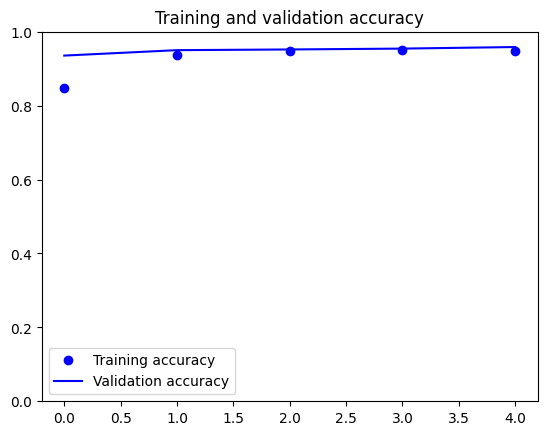

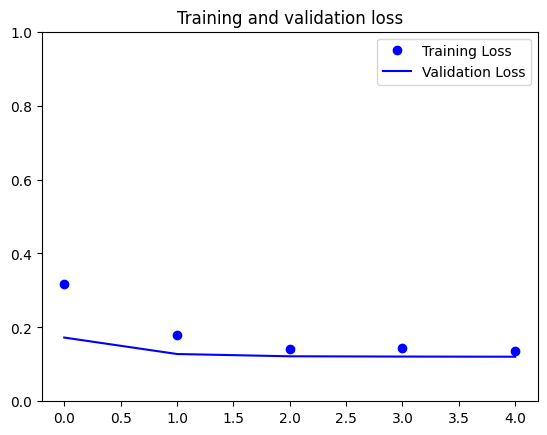

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylim([0,1])
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.ylim([0,1])
plt.legend()
plt.show()

In [26]:
test_text_dataset = test_dataset.map(lambda x, y: x)
test_texts = np.concatenate([x.numpy() for x in test_text_dataset])

test_labels_dataset = test_dataset.map(lambda x, y: y)
test_labels = np.concatenate([y.numpy() for y in test_labels_dataset])

In [27]:
model_eval = model.evaluate(test_dataset)

141/141 [==============================] - 14s 100ms/step - loss: 0.1194 - accuracy: 0.9588


In [28]:
model_pred = model.predict(test_dataset)
model_pred = np.argmax(model_pred, axis=1)

141/141 [==============================] - 25s 127ms/step


Text(0.5, 1.0, 'RNN Accuracy Score: 0.9587973356246948')

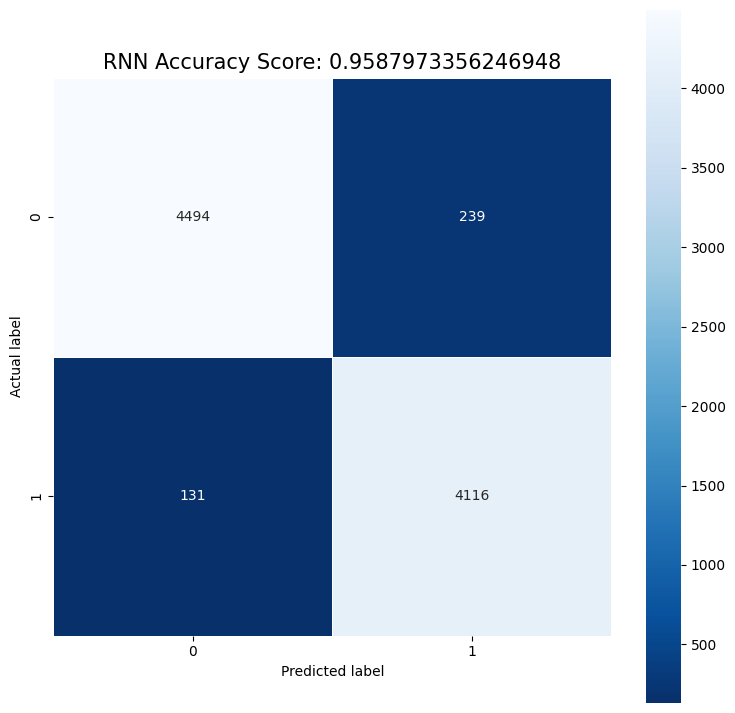

In [29]:
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(test_labels, model_pred), annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('RNN Accuracy Score: {0}'.format(model_eval[1]), size = 15)

In [30]:
report = classification_report(test_labels, model_pred, output_dict=True)
report_df = pd.DataFrame.from_dict(report)
report_df.index.name = 'RNN Classification Report'
report_df.head(50).transpose()

RNN Classification Report,precision,recall,f1-score,support
0,0.971676,0.949503,0.960462,4733.000000
1,0.945121,0.969155,0.956987,4247.000000
accuracy,0.958797,0.958797,0.958797,0.958797
macro avg,0.958398,0.959329,0.958724,8980.000000
weighted avg,0.959117,0.958797,0.958818,8980.000000


# Model Testing

In [31]:
sample_text = ('NASA confirms aliens have been living among us for centuries.')

text_predict = model.predict(np.array([sample_text]))
text_predict = np.argmax(text_predict, axis=1)
print(text_predict)

1/1 [==============================] - 10s 10s/step
[0]


In [32]:
sample_text = ('Labor, Anthony Albanese make history with 2022 federal election victory')

text_predict = model.predict(np.array([sample_text]))
text_predict = np.argmax(text_predict, axis=1)
print(text_predict)

1/1 [==============================] - 0s 23ms/step
[1]
